In [1]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import csv
import tqdm

# train on data or not:

In [ ]:
train = False

# Prepering the data

In [2]:
files = glob('data_set/*.csv')

In [3]:
my_file = []
def delete_lines_and_save(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Delete the first five lines
    modified_lines = lines[5:]

    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows([line.strip().split(',') for line in modified_lines])

    #print(f"Modified CSV file saved as '{output_file}'.")


for file in files:
    delete_lines_and_save(file, 'drop 5 lines data_set/' + file.split('\\')[1])
    my_file.append('drop 5 lines data_set/' + file.split('\\')[1])

In [4]:
def convert_to_floats(dataframe):
    for column in dataframe.columns:
        dataframe[column] = pd.to_numeric(dataframe[column].astype(str).str.replace('"', ''), errors='coerce')
    return dataframe

import re

data = []
for file in my_file:
    #print(file)
    d = pd.read_csv(file)

    file_name = "data_set/" + file.split('/')[1]
    with open(file_name, 'r') as file1:
        lines = file1.readlines()
    sanity_check = "COUNTS OF ACTUAL STEPS:" in lines[3].split(',')[0] or "COUNT OF ACTUAL STEPS:" in lines[3].split(',')[0]
    if not sanity_check:
        steps = lines[3].split(',')[0]
    else:
        steps = lines[3].split(',')[1]

    # get first int from string with regex
    steps = int(re.findall(r'\d+', steps)[0])

    #delete every column geater than 3
    #d = d.loc[:, d.columns != 'Unnamed: 4']

    # take the first 4 columns
    d = d.iloc[:, :4]

    # values to float from string with apply
    
    d = convert_to_floats(d)
    
    
    # rename columns
    d.columns = ['time', 'acc_x', 'acc_y', 'acc_z']
    walking = "walk" in file
    data.append([d, walking, steps])

# Walking or Running

In [7]:
def classify(data):
    # max l2 norm of acceleration
    norms = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)
    
    # max acceleration
    max_acc = np.max(norms)

    max_acc = min(max_acc, 50)

    return max_acc > 20, max_acc

In [8]:
classify(data[0][0])

(True, 30.988983526408223)

In [9]:
import tqdm
# lets calculate the accuarcy of the classifier
true_labels = []
predicted_labels = []
my_dict = {"walking":[], "running":[]}
for d in tqdm.tqdm(data):
    frame_labels = []
    for i in range(20, len(d[0])):

        # take the last 10 values
        last_20 = d[0].iloc[i-20:i]
        # classify
        classified, max_acc = classify(last_20)
        # append predicted label
        frame_labels.append(classified)

        # append to dict
        if d[1]:
            my_dict["walking"].append(max_acc)
        else:
            my_dict["running"].append(max_acc)
    
    pred = np.mean(frame_labels) < 0.5

    true_labels.append(d[1])
    predicted_labels.append(pred)

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

100%|██████████| 280/280 [01:38<00:00,  2.84it/s]


### predictions:

In [12]:
# prediction
print("True -> Walking, False -> Running")
print(predicted_labels)

True -> Walking, False -> Running
[False False False False False  True  True  True  True  True False False
 False False False  True  True  True  True  True False False False False
 False  True  True  True  True  True False  True  True  True False  True
  True  True  True  True False  True False  True False  True  True  True
  True  True False False False False False  True  True  True  True False
 False False False False False  True  True  True  True  True False False
 False False False  True  True  True  True  True False False False False
 False  True  True  True  True  True False False False False False  True
  True  True False  True False False False False False False False False
 False False  True False False False False  True  True  True  True  True
 False  True False False  True  True  True  True  True  True False False
 False False False False False  True  True  True False False False False
 False False False False False False False False False False False  True
  True  True  Tru

### accuracy:

In [13]:
# calculate accuracy
accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
accuracy

0.9

### plots

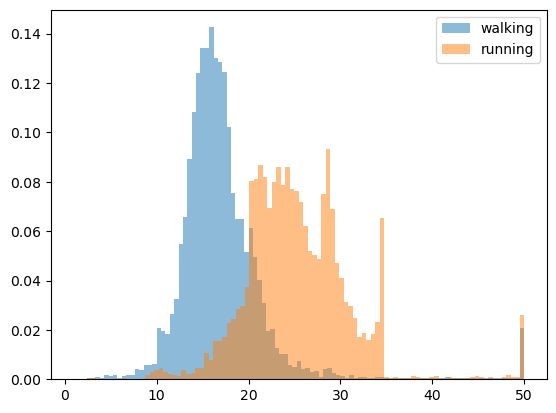

In [14]:
# plot the distribution of the max acceleration
import matplotlib.pyplot as plt

# normalize to distribution
plt.hist(my_dict["walking"], bins=100, alpha=0.5, label='walking', density=True)
plt.hist(my_dict["running"], bins=100, alpha=0.5, label='running', density=True)
plt.legend(loc='upper right')
plt.show()

# How many steps

In [15]:
def smooth_signal_fast(lst, window_size=10):
    cumsum_vec = np.cumsum(np.insert(lst, 0, 0))
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

In [16]:
def exp_smooth_signal(lst, alpha=0.1):
    s = np.zeros(len(lst))
    s[0] = lst[0]
    for i in range(1, len(lst)):
        s[i] = alpha * lst[i] + (1 - alpha) * s[i-1]
    return s
    

In [17]:
# classic method for counting steps
from scipy.signal import find_peaks

def count_steps(data, threshold=1.8, distance=3, low_pass=350):
    # Apply Fast Fourier Transform (FFT)
    fft_values = np.fft.rfft(data)
    
    # Low pass filter
    fft_values[low_pass:] = 0

    # Apply Inverse Fast Fourier Transform (IFFT) to get the filtered signal
    data = np.fft.irfft(fft_values)

    peaks, _ = find_peaks(data, threshold=threshold, distance=distance)
    return str(len(peaks))

In [48]:
if train == True:
    best_treshold = {"walking": 1.5, "running": 1.5}
    best_distance = {"walking": 0.35, "running": 0.35}
    best_loss = {"walking": 1, "running": 1}
    best_low_pass = {"walking": 350, "running": 350}

    best_window_size = {"walking": 10, "running": 10}

    blacklist = [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]

    win_size = 0.35

    for treshold in tqdm.tqdm(np.arange(0, 0.02, 0.001)):
        for low_pass in [260, 270, 280, 290, 300, 310]:
            for distance in np.arange(2, 5, 1):

                    real = {"walking": [], "running": []}
                    pred = {"walking": [], "running": []}
                    for idx, d in enumerate(data):
                        if idx in blacklist:
                            continue

                        if d[1]:
                            category = "walking"
                        else:
                            category = "running"

                        # calc l2 norm of acceleration
                        norms = np.sqrt(d[0]['acc_x']**2 + d[0]['acc_y']**2 + d[0]['acc_z']**2)
            
                        # remove nan values
                        norms = norms[~np.isnan(norms)]
                        
                        # norms to float array
                        lst = np.array(norms)

                        m = np.mean(lst)

                        if m > 35:
                            continue

                        # if norm > 35  then norm = m
                        lst[lst > 35] = m

                        # normalize
                        lst = (lst - m) / np.std(lst)

                        #lst = smooth_signal_fast(lst, window_size=win_size)
                        lst = exp_smooth_signal(lst, alpha=win_size)

                        cs = count_steps(lst, threshold=treshold, distance=distance, low_pass=low_pass)

                        real[category].append(d[2])
                        pred[category].append(int(cs))

                    # calc loss
                    for c in ["walking", "running"]:
                        r = np.array(real[c])
                        p = np.array(pred[c])
                        loss = np.abs(1 - p / r)

                        if np.mean(loss) < best_loss[c]:
                            best_loss[c] = np.mean(loss)
                            best_treshold[c] = treshold
                            best_distance[c] = distance
                            best_window_size[c] = win_size
                            best_low_pass[c] = low_pass

else:
    best_treshold = {'walking': 0.042, 'running': 0.01}
    best_distance = {'walking': 4, 'running': 3}
    best_window_size = {'walking': 0.35, 'running': 0.35}
    best_low_pass = {'walking': 310, 'running': 290}

In [50]:
# print("best_loss = {" + f"\"walking\": {best_loss['walking']}, \"running\": {best_loss['running']}" + "}")
# print("best_treshold = {" + f"\"walking\": {best_treshold['walking']}, \"running\": {best_treshold['running']}" + "}")
# print("best_distance = {" + f"\"walking\": {best_distance['walking']}, \"running\": {best_distance['running']}" + "}")
# print("best_low_pass = {" + f"\"walking\": {best_low_pass['walking']}, \"running\": {best_low_pass['running']}" + "}")
# print("best_window_size = {" + f"\"walking\": {best_window_size['walking']}, \"running\": {best_window_size['running']}" + "}")

# plot stuff

In [58]:
real = {"walking": [], "running": []}
pred = {"walking": [], "running": []}

blacklist = [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]

best_median = {"walking": 0, "running": 0}

pred_steps = {}

for idx, d in enumerate(data):
    if idx in blacklist:
        continue
    
    if d[1]:
        category = "walking"
    else:
        category = "running"

    # calc l2 norm of acceleration
    norms = np.sqrt(d[0]['acc_x']**2 + d[0]['acc_y']**2 + d[0]['acc_z']**2)
    
    # remove nan values
    norms = norms[~np.isnan(norms)]

    m = np.mean(norms)

    if m > 35:
        continue

    # if norm > 35  then norm = m
    norms[norms > 35] = m

    # normalize
    norms = (norms - m) / np.std(norms)

    # smooth
    norms = np.array(norms)
    #norms = smooth_signal_fast(norms, window_size=best_window_size[category])
    norms = exp_smooth_signal(norms, alpha=best_window_size[category])

    # norms to float array
    lst = np.array(norms)

    threshold=best_treshold[category]
    distance=best_distance[category]

    cs = count_steps(lst, threshold=threshold, distance=distance, low_pass=best_low_pass[category])

    real[category].append(d[2])
    pred[category].append(int(cs))

    pred_steps[idx] = int(cs)

# calc loss
for c in ["walking", "running"]:
    r = np.array(real[c])
    p = np.array(pred[c])
    loss = np.abs(1 - p / r)
    best_median[c] = np.median(loss)
    print(c, "MARD =", np.median(loss))

walking MARD = 0.16574585635359118
running MARD = 0.07096774193548383


### predictions:

In [64]:
# prediction:

print("prediction:")
print(pred_steps.values())

prediction:
dict_values([128, 137, 129, 126, 126, 77, 89, 102, 71, 73, 144, 141, 150, 149, 151, 82, 86, 68, 81, 78, 90, 91, 94, 150, 145, 78, 75, 91, 92, 125, 143, 216, 159, 43, 84, 93, 93, 98, 91, 101, 102, 116, 120, 64, 72, 71, 20, 25, 27, 17, 15, 26, 22, 167, 146, 160, 142, 150, 31, 87, 91, 90, 102, 128, 125, 121, 143, 139, 83, 91, 72, 86, 84, 116, 108, 113, 61, 72, 44, 50, 74, 65, 66, 64, 85, 113, 84, 126, 56, 67, 70, 67, 87, 149, 156, 145, 133, 137, 95, 90, 99, 103, 87, 146, 155, 146, 151, 151, 115, 96, 95, 99, 106, 84, 99, 100, 110, 155, 51, 81, 83, 55, 75, 68, 70, 100, 89, 69, 114, 129, 72, 208, 216, 136, 105, 134, 130, 119, 117, 97, 100, 105, 148, 58, 40, 40, 40, 58, 67, 45, 78, 35, 132, 121, 106, 97, 117, 99, 81, 86, 72, 85, 36, 26, 27, 23, 52, 17, 22, 31, 22, 19, 169, 162, 156, 142, 146, 70, 79, 83, 83, 93, 110, 116, 104, 92, 122, 94, 81, 151, 140, 115, 190, 204, 151, 212, 206, 97, 109, 109, 122, 128, 56, 57, 68, 67, 58, 58, 40, 39, 67, 73, 137, 129, 143, 134, 138, 87, 87, 90

### plots

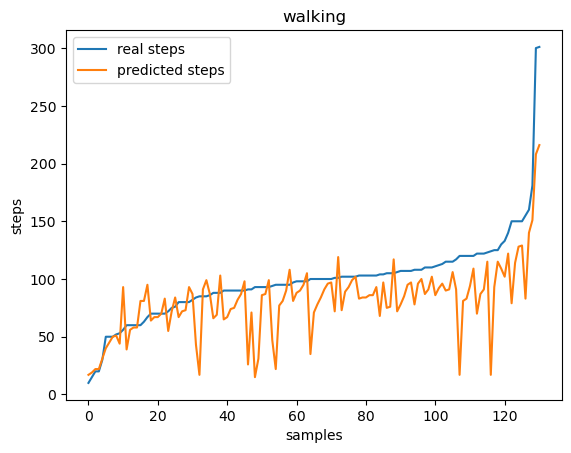

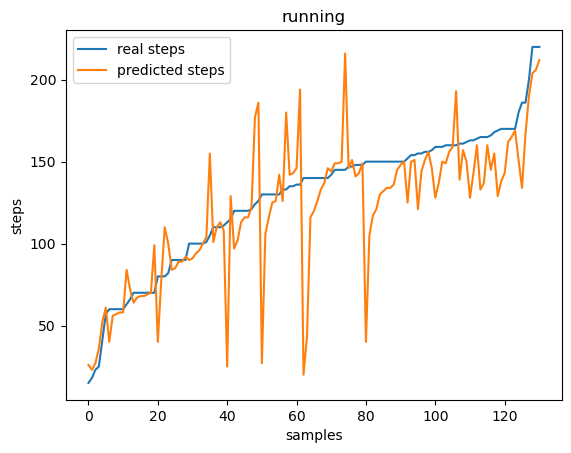

In [68]:
# plot beutiful graphs

# zip them
# sort them
# unzip them
# plot them

import matplotlib.pyplot as plt

for category in ["walking", "running"]:
    r = np.array(real[category])
    p = np.array(pred[category])
    r, p = zip(*sorted(zip(r, p)))
    plt.plot(r, label = "real steps")
    plt.plot(p, label = "predicted steps")
    plt.xlabel("samples")
    plt.ylabel("steps")
    plt.legend(loc='upper left')
    plt.title(category)
    plt.show()

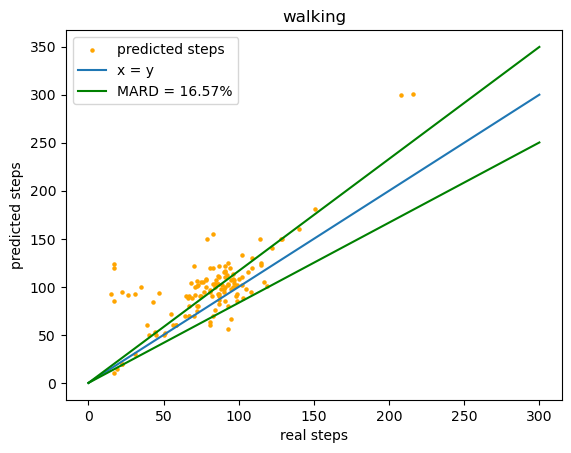

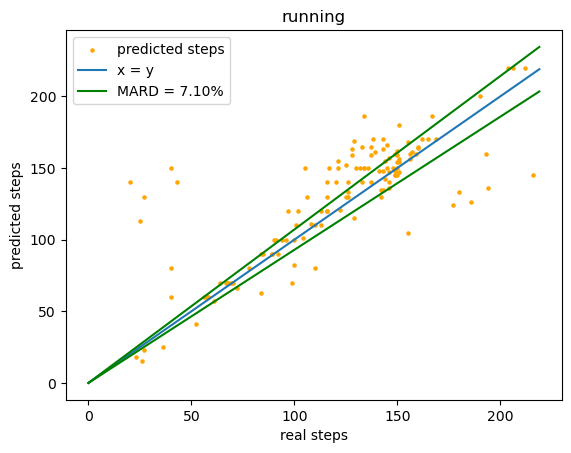

In [69]:
for category in ["walking", "running"]:
    r = np.array(real[category])
    p = np.array(pred[category])
    r, p = zip(*sorted(zip(r, p)))
    plt.scatter(p, r, label = "predicted steps", s=5, color = "orange")
    # straigh line
    plt.plot(np.arange(0, max(r)), np.arange(0, max(r)), label = "x = y")
    # ten precent relative error
    plt.plot(np.arange(0, max(r)), np.arange(0, max(r)) * (1 + best_median[category]), label = f"MARD = {best_median[category] * 100:.2f}%", color = "green")
    # ten precent relative error
    plt.plot(np.arange(0, max(r)), np.arange(0, max(r)) * (1 - best_median[category]), color = "green")
    plt.xlabel("real steps")
    plt.ylabel("predicted steps")
    plt.legend(loc='upper left')
    plt.title(category)
    plt.show()